# **Transfer Learning with Pre-Trained Tensorflow Hub Model**

In this Jupyter Notebook, we will run through the steps of building and training a model with Tensorflow [1], which will identify fake product reviews within our Amazon Database [2]. This model is developed to experiment and demonstrate the possibilities of Transfer Learning.

[1] <b>Tensorflow</b>; "An end-to-end open source machine learning platform.", https://www.tensorflow.org/   
[2] <b>Amazon Database</b>; https://www.kaggle.com/lievgarcia/amazon-reviews/

<div>
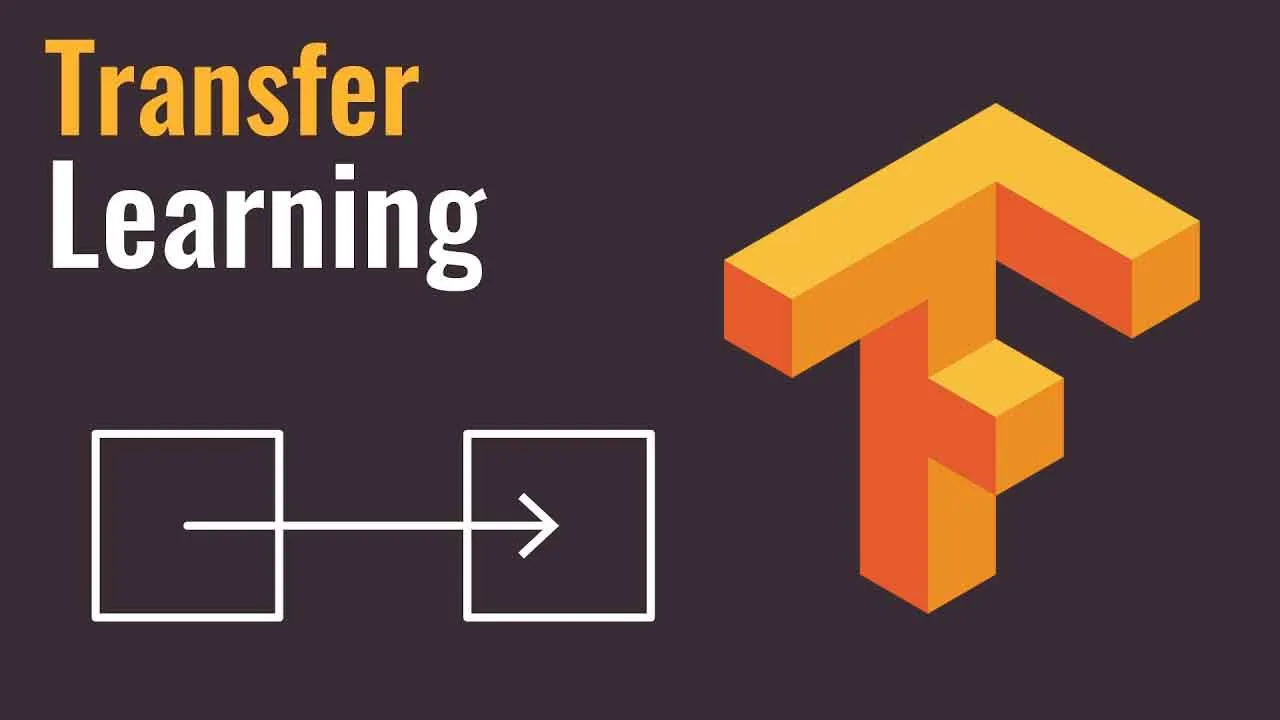
</div>

As defined by Tensorflow, Transfer Learning [1] is the process of adopting a model which was pre-trained on a large and general dataset and customizing it (retraining) according to the problem that we are trying to solve. This way, we can take advantage of the experience that the model already gained from the large dataset, which results in having to perform significantly less training of our own model while still gaining the functionality that we aimed to have.

[1] <b>Transfer Learning</b>; https://www.tensorflow.org/tutorials/images/transfer_learning

# **Import the packages**

In [1]:
import os.path
import wget
import shutil

import numpy as np
import pandas as pd

import tensorflow as tf

import tensorflow.keras as keras
import tensorflow_hub as hub

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# **Data Analysis and pre-processing**

*Assumption:* We use pandas to read the data. Our text file is 'tab' delimited. Hence we use *delimiter=\t* in the read_csv() of pandas. Some rows of the data has missing columns. We want to remove these columns during preprocessing. Hence we have the argument *error_bad_lines=False* which will make sure some of the rows with missing values will not be read. 

In [2]:
if not os.path.isfile('amazon_reviews.txt'): # downloads db to train if it does not exist in the directory
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download' # db to train
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')
    print('Done!')

train_df = pd.read_csv('amazon_reviews.txt', delimiter='\t', error_bad_lines=False)

**Analyse the data** <br/>
We use the head() of the pandas package to see what our data looks like.

In [3]:
train_df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


We observe that the 'LABEL' column is Categorical. In order to use this dataset to work with Deep learning models, we need to convert these Categorical values to numerical values.

In [4]:
# Converting categorical 'LABEL' values to numerical

train_df['LABEL'] = pd.Categorical(train_df['LABEL'])
train_df['LABEL'] = train_df['LABEL'].cat.codes

Dropping irrevelant feature columns such as 'DOC_ID', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY', 'PRODUCT_ID', 'PRODUCT_TITLE', 'REVIEW_TITLE'

In [5]:
features = ["REVIEW_TEXT", "RATING", "LABEL"]

train_shortened_df = train_df[features]

**Analyse the data** <br/>
We use the head() of the pandas package to see what our data looks like. From this data we can see that 'LABEL' is the column we are trying to predict. To predict this value we make use of different features from the data. 
The different features we are using are 'RATING', 'REVIEW_TEXT' and 'VERIFIED_PURCHASE'.

In [6]:
train_shortened_df.head()

,REVIEW_TEXT,RATING,LABEL
0,"When least you think so, this product will sav...",4,0
1,Lithium batteries are something new introduced...,4,0
2,I purchased this swing for my baby. She is 6 m...,3,0
3,I was looking for an inexpensive desk calcolat...,4,0
4,I only use it twice a week and the results are...,4,0


We are now introduced to a simpler dataset with the 'LABEL' Column converted from Categorical to Numerical values.

To work with Deep learning models we need to convert REVIEW_TEXT and LABEL values to Numpy Arrays

# Train, validation and test split with Shuffling

We have the data to work with and we need to split it to training set, validation set and test set. We train our model on the training set, tune our hyperparameters on the validation set and finally use it on the test set. We split the data into 80% training set, 10% validation set and 10% test set.

Shuffling the data such that training and validation dataset has both of the labels. This is crucial for an efficient training and is automatically done by the 'train_test_split' of Sklearn Library.

In [7]:
x_train, x_testval, y_train, y_testval = train_test_split(train_shortened_df[['REVIEW_TEXT']], train_shortened_df[['LABEL']] , test_size = 0.20)
x_test, x_val, y_test, y_val = train_test_split(x_testval[['REVIEW_TEXT']], y_testval[['LABEL']] , test_size = 0.50)

# Build the model

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2" # pre-trained Tensoflow Hub Model

# trainable=False means we have frozen the weights of the pre-trained model, no training will happen on these weights for now
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False) 

model_classifier = tf.keras.Sequential()
model_classifier.add(hub_layer)  # Adding pre-trained Tensorflow Hub Model to our own model

model_classifier.add(Dense(16, activation='relu'))

# 1D outputting final layer with Sigmoid Activation Function to predict Fake Reviews (LABEL) in a Binary Fashion
model_classifier.add(Dense(1, activation='sigmoid'))

The model is compiled using the ADAM optimizer and Binary Cross Entropy loss

In [9]:
model_classifier.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])

In [10]:
model_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


# Training the Model

In [11]:
history_frozen_weights = model_classifier.fit(x_train,
                            y_train,
                            epochs=60,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1)

model_classifier.save("fakeReviewDetector_frozen_weights.hdf5")

Epoch 1/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6773 - acc: 0.5735 - val_loss: 0.6657 - val_acc: 0.5986
Epoch 2/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6603 - acc: 0.5999 - val_loss: 0.6607 - val_acc: 0.5967
Epoch 3/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6555 - acc: 0.6042 - val_loss: 0.6589 - val_acc: 0.5995
Epoch 4/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6527 - acc: 0.6074 - val_loss: 0.6558 - val_acc: 0.6010
Epoch 5/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6500 - acc: 0.6152 - val_loss: 0.6545 - val_acc: 0.6038
Epoch 6/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6482 - acc: 0.6180 - val_loss: 0.6534 - val_acc: 0.6019
Epoch 7/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6464 - acc: 0.6232 - val_loss: 0.6521 - val_acc: 0.6014
Epoch 8/60
525/525 [==============================] - 1s 3ms/step - loss: 0.

Final evaluation of the performance of the Model on the <b>unseen</b> test dataset.

In [12]:
results = model_classifier.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results[1]} ')

66/66 [==============================] - 0s 4ms/step - loss: 0.6343 - acc: 0.6290
Evaluation on all data has accuracy of: 0.6290476322174072 


# Visualizing the results

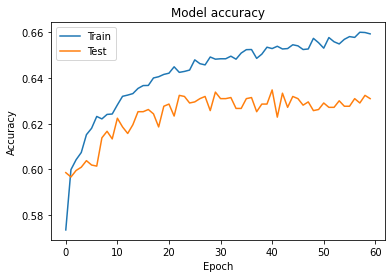

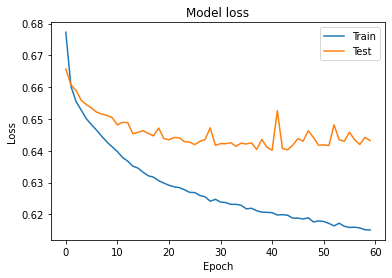

In [13]:
plt.plot(history_frozen_weights.history['acc'])
plt.plot(history_frozen_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_frozen_weights.history['loss'])
plt.plot(history_frozen_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluating the Training Result

* From the Training Logs and the two graphs above, it can be clearly seen that after some epochs the accuracy and the loss values of the training and test set differentiate from each other. Even though the loss and accuracy metrics of the training set continue to improve, the training metrics of the validation set are not improving. This is a serious problem because we want this metrics to improve during training, so that we can come up to a successful model. The problem we are facing in such situation is called "<b>Overfitting</b>".

* Another issue with the metrics above is that even after performing training for 60 epochs, the loss metric of the training dataset actually does not converge near 0.01 as well as its accuracy not converging near 0.99. This issue is related with the <b>capacity (number of trainable weights)</b> of our model. If we once again observe the summary of our model created with the command <i>model_classifier.summary()</i> above, it is seen that the number of trainable parameters of our model is 833, which seems to be not enough to handle our dataset.

<hr>

# Overfitting

Coming up to a simple definition for <b>Overfitting</b>, it is the behaviour of a model under training that memorizes the training dataset introduced to it, as was mentioned at the <i>Applied Deep Learning for NLP Seminar</i> at the Technical University of Munich. The main characteristic behavior one can use to detect this problem is when the training loss is continuously decreasing but the validation accuracy has no improvements and if not prevented will start to even increase in the upcoming epochs.

This is the problem we are exactly having during the training of the model and this can be clearly seen from the graphs above, where the loss of the training data decreases but in contrast to it the loss of the validation data increases.

# Solution 1 - Preventing Overfitting

In order to prevent the problem of overfitting and coming up to a better model, we will now apply an approach called the "<b>Early Stopping</b>". Tensorflow already implements this feature and allows us to use it via the help of callbacks that are provided to the fit function, which is used to start the traing of the model.

While defining our callbacks array, we have asked Tensorflow to monitor the validation accuracy for the process and to restore to the best combination of weights that were ever reached during training. When Tensorflow monitors the validation loss as a metric for Early Stopping, it will terminate the training process after a pre-defined number of epocs where the validation accuracy was not able to be improved. This pre-defined number is included in the process through the "<b>patience</b>" parameter.

In [14]:
# The same model is re-defined to prevent the training from continuing on top of the process previously achieved 

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)

model_classifier_weights_frozen_earlyStopping = tf.keras.Sequential()
model_classifier_weights_frozen_earlyStopping.add(hub_layer)  # Transfer Learning for pre-trained word embeddings
model_classifier_weights_frozen_earlyStopping.add(Dense(16, activation='relu'))
model_classifier_weights_frozen_earlyStopping.add(Dense(1, activation='sigmoid'))

model_classifier_weights_frozen_earlyStopping.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])


callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_acc", patience=5,
                                        verbose=1, mode="min", restore_best_weights=True)
]
    
history_frozen_weights_early_stopping = model_classifier_weights_frozen_earlyStopping.fit(x_train,
                            y_train,
                            epochs=60,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=callbacks)

model_classifier_weights_frozen_earlyStopping.save("fakeReviewDetector_frozen_weights_earlyStopping.hdf5")

Epoch 1/60
525/525 [==============================] - 2s 4ms/step - loss: 0.6807 - acc: 0.5612 - val_loss: 0.6677 - val_acc: 0.5848
Epoch 2/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6628 - acc: 0.5989 - val_loss: 0.6591 - val_acc: 0.5957
Epoch 3/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6573 - acc: 0.6043 - val_loss: 0.6568 - val_acc: 0.5910
Epoch 4/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6546 - acc: 0.6088 - val_loss: 0.6550 - val_acc: 0.6010
Epoch 5/60
525/525 [==============================] - 1s 3ms/step - loss: 0.6522 - acc: 0.6139 - val_loss: 0.6542 - val_acc: 0.6014
Epoch 6/60
525/525 [==============================] - 2s 3ms/step - loss: 0.6502 - acc: 0.6194 - val_loss: 0.6528 - val_acc: 0.6014
Epoch 00006: early stopping


Final evaluation of the performance of the Model on the unseen test dataset.

In [15]:
results = model_classifier_weights_frozen_earlyStopping.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results[1]} ')

66/66 [==============================] - 0s 3ms/step - loss: 0.6695 - acc: 0.5886
Evaluation on all data has accuracy of: 0.5885714292526245 


# Visualizing the results

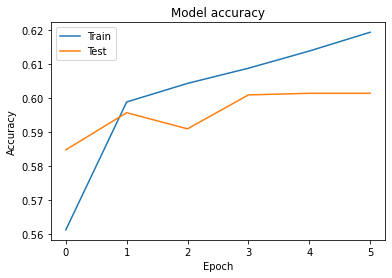

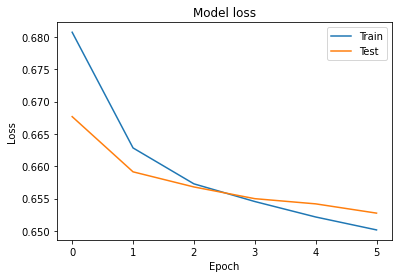

In [16]:
plt.plot(history_frozen_weights_early_stopping.history['acc'])
plt.plot(history_frozen_weights_early_stopping.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_frozen_weights_early_stopping.history['loss'])
plt.plot(history_frozen_weights_early_stopping.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluating the Training Result

The model is still not fully trained since the training loss hasn't converged near 0.01. This is due to the model's capacity being not enough as was previously mentioned.

<hr>

# Solution 2 - Using Fine Tuning to Increase the Capacity of the Model

In [17]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)


model_classifier_weights_unfrozen = tf.keras.Sequential()
model_classifier_weights_unfrozen.add(hub_layer)  # Transfer Learning for pre-trained word embeddings

model_classifier_weights_unfrozen.add(Dense(16, activation='relu'))
model_classifier_weights_unfrozen.add(Dense(1, activation='sigmoid'))

In [18]:
model_classifier_weights_unfrozen.compile(optimizer='adam',
                    loss=tf.losses.BinaryCrossentropy(),
                    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='acc')])

In [19]:
model_classifier_weights_unfrozen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=3,
                                        verbose=1, mode="min", restore_best_weights=True)
]

history_unfrozen_weights = model_classifier_weights_unfrozen.fit(x_train,
                            y_train,
                            epochs=60,
                            batch_size=256,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=callbacks)

model_classifier_weights_unfrozen.save("fakeReviewDetector_unfrozen_weights.hdf5")

Epoch 1/60
66/66 [==============================] - 5s 73ms/step - loss: 0.6787 - acc: 0.5660 - val_loss: 0.6528 - val_acc: 0.6138
Epoch 2/60
66/66 [==============================] - 5s 71ms/step - loss: 0.6181 - acc: 0.6609 - val_loss: 0.6177 - val_acc: 0.6610
Epoch 3/60
66/66 [==============================] - 5s 71ms/step - loss: 0.5538 - acc: 0.7218 - val_loss: 0.6023 - val_acc: 0.6667
Epoch 4/60
66/66 [==============================] - 4s 68ms/step - loss: 0.4833 - acc: 0.7812 - val_loss: 0.6084 - val_acc: 0.6662
Epoch 5/60
66/66 [==============================] - 4s 67ms/step - loss: 0.4083 - acc: 0.8271 - val_loss: 0.6370 - val_acc: 0.6557
Epoch 6/60
66/66 [==============================] - 5s 68ms/step - loss: 0.3372 - acc: 0.8662 - val_loss: 0.6889 - val_acc: 0.6357
Epoch 00006: early stopping


Final evaluation of the performance of the Model on the unseen test dataset.

In [21]:
results_unfrozen = model_classifier_weights_unfrozen.evaluate(x_test[['REVIEW_TEXT']],  y_test["LABEL"])

print(f'Evaluation on all data has accuracy of: {results_unfrozen[1]} ')

66/66 [==============================] - 0s 4ms/step - loss: 0.6183 - acc: 0.6643
Evaluation on all data has accuracy of: 0.6642857193946838 


# Visualizing the results

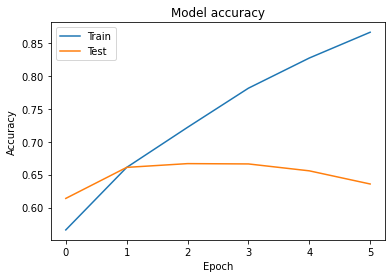

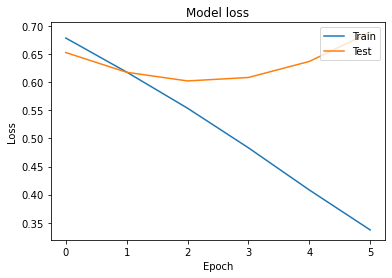

In [22]:
plt.plot(history_unfrozen_weights.history['acc'])
plt.plot(history_unfrozen_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_unfrozen_weights.history['loss'])
plt.plot(history_unfrozen_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluating the Training Result

We will once again observe the number of our trainable parameters like we have previously done so. When the command <i>model_classifier.summary()</i> is executed above, it is seen that our current model now has a total of 48,191,433 <b>Trainable Parameters</b>. As an expected behaviour, our training loss has converged near 0.01, meaning that it has been trained to the maximum extend. However once again we have the problem that validation loss hasn't decreased.

Even though we used <b>Early Stopping</b> like we have previously done so, it couldn't prevent overfitting. The reason for this is that this time our model has about 60 times more trainable parameters than it used to have, meaning that the model's capacity overcomes the size of our database. In order to prevent this, one can do the following;

* Reduce the capacity of the model by using methods such as <b>Dropout</b>.
* Switching to a similar but larger dataset.

<hr>

# Solution 3 - Reducing the Capacity of the Model

Since in our latest model we have imported a pre-trained Tensorflow Hub model to perform Transfer Learning and almost all of our trainable parameters come directly from the imported model, we are unable to perform capacity reduction on the model. One thing that could have been done was to adopt a simpler pre-trained model from Tensorflow Hub. However as can be seen from the link [1], the model that we have choosen was already the lightest one.

[1] https://tfhub.dev/s?fine-tunable=yes&module-type=text-embedding&q=Token%20based%20text%20embedding%20trained

<hr>

# Solution 4 - Switching to a similar but larger Dataset

This solution was not possible in the scope of the Applied Deep Learning for NLP Seminar since we already had proposed a project to the Proffessor and had to work on the initial dataset that we had choosen.

<hr>

# Solution 5 - Using more features from our Dataset for Training